# Radom bcc alloy

In [26]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from lammps_implicit_der.systems import BCC_BINARY
from lammps_implicit_der import SNAP
from lammps_implicit_der.tools import error_tools, plot_tools

## Define a non-perturbed random alloy system

In [27]:
# Check if the bcc_random.data file exists
datafilename = 'bcc_random.data'
datafile = datafilename if os.path.exists(datafilename) else None

#datafile = None

bcc_alloy_non_perturb = BCC_BINARY(datafile=datafile,
                                  snapcoeff_filename='NiMo.snapcoeff',
                                  ncell_x=2,
                                  specie_B_concentration=0.5,
                                  minimize=True)

if datafile is None:
    bcc_alloy_non_perturb.write_data(datafilename)


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Reading datafile bcc_random.data
Setting SNAP potential

                  SNAP coefficients for: Ni Mo
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R =  0.5750 w =  0.5000
                                Element: Mo  |  R =  0.5750 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 1 steps
Initial fmax: 2.396e-09, final fmax: 2.257e-09
Initial fnorm: 8.923e-09, final fnorm: 5.999e-09
Number of atoms: 16, largest force value: 2.257e-09, force norm: 5.999e-09


In [28]:
print(bcc_alloy_non_perturb.cell)
print(bcc_alloy_non_perturb.species)

[[6.26 0.   0.  ]
 [0.   6.26 0.  ]
 [0.   0.   6.26]]
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]


## SNAP potential parameters perturbation

In [29]:
print(bcc_alloy_non_perturb.pot.Theta_dict['Mo'])

{'elem_params': {'radius': 0.575, 'weight': 1.0}, 'beta0': -11.1413071988, 'Theta': array([ 0.00217993,  0.02117406,  0.05027489,  0.01271017,  0.32806724,
        0.06901471,  0.1782036 ,  0.00128021,  0.06856159,  0.02934277,
        0.0085863 , -0.00900972,  0.00302195,  0.02371238,  0.00319153,
        0.03359465,  0.06278455, -0.06161855, -0.02141344, -0.0348541 ,
        0.01435036,  0.00391291,  0.02266774, -0.02309605, -0.02843036,
        0.00857356,  0.00335881,  0.03927386, -0.00041452, -0.00370094])}


In [30]:
# Get the Mo Theta parameters
Theta_Mo = bcc_alloy_non_perturb.pot.Theta_dict['Mo']['Theta'].copy()

# Strongly perturb the Mo Theta parameters
delta = 0.5

dTheta = Theta_Mo * np.random.uniform(-1.0, 1.0, size=Theta_Mo.shape) * delta

Theta_Mo_perturb = Theta_Mo + dTheta

# Copy from the original potential
Theta_dict_perturb = deepcopy(bcc_alloy_non_perturb.pot.Theta_dict)
Theta_dict_perturb['Mo']['Theta'] = Theta_Mo_perturb

snapparam_dict = deepcopy(bcc_alloy_non_perturb.pot.snapparam_dict)
elem_list = bcc_alloy_non_perturb.pot.elem_list.copy()

# Define a SNAP instance with the perturbed parameters
perturbed_snap = SNAP(elem_list, Theta_dict_perturb, snapparam_dict)

# Save the perturbed SNAP coefficients to a file
snapcoeff_filename = 'NiMo_Mo_perturbed.snapcoeff'
snapparam_filename = 'NiMo_Mo_perturbed.snapparam'

# Do it once
#today_is_the_day = True
today_is_the_day = False

if today_is_the_day:
    perturbed_snap.to_files(path='.',
                            snapcoeff_filename=snapcoeff_filename,
                            snapparam_filename=snapparam_filename,
                            overwrite=True,
                            verbose=True)

## Perturbed random alloy system

In [31]:
bcc_alloy_perturb = BCC_BINARY(datafile=datafile,
                              data_path='../../lammps_implicit_der/data_files',
                              snapcoeff_filename='NiMo_Mo_perturbed.snapcoeff',
                              ncell_x=3,
                              minimize=True)


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Reading datafile bcc_random.data
Setting SNAP potential

                  SNAP coefficients for: Ni Mo
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R =  0.5750 w =  0.5000
                                Element: Mo  |  R =  0.5750 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 85 steps
Initial fmax: 7.990e-01, final fmax: 3.358e-09
Initial fnorm: 2.442e+00, final fnorm: 6.789e-09
Number of atoms: 16, largest force value: 3.358e-09, force norm: 6.789e-09


## Coordinates

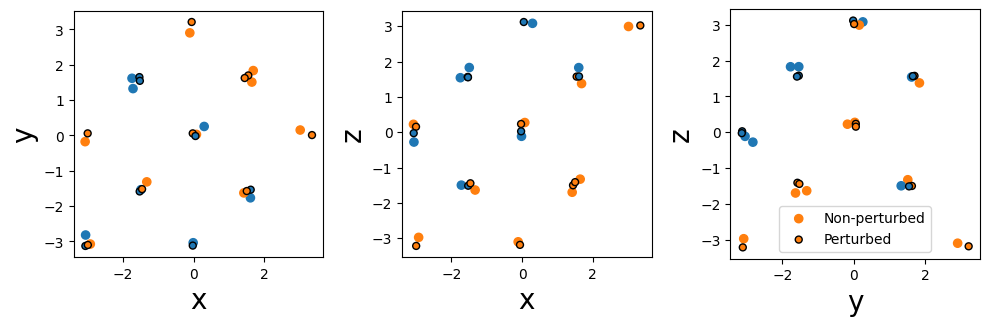

In [32]:
X0 = bcc_alloy_non_perturb.X_coord.copy()
X1 = bcc_alloy_perturb.X_coord.copy()

X1 = X0.copy() + bcc_alloy_non_perturb.minimum_image(X1 - X0)

X0 = X0.reshape(-1, 3)
X1 = X1.reshape(-1, 3)

species = bcc_alloy_non_perturb.species

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
specie_color = {1: 'tab:orange', 2: 'tab:blue'}
colors = [specie_color[s] for s in species]
plot_tools.plot_coords(axes, X0, c=colors, s=35, label='Non-perturbed')
plot_tools.plot_coords(axes, X1, c=colors, s=25, label='Perturbed', edgecolors='black')
plt.tight_layout()
plt.show()


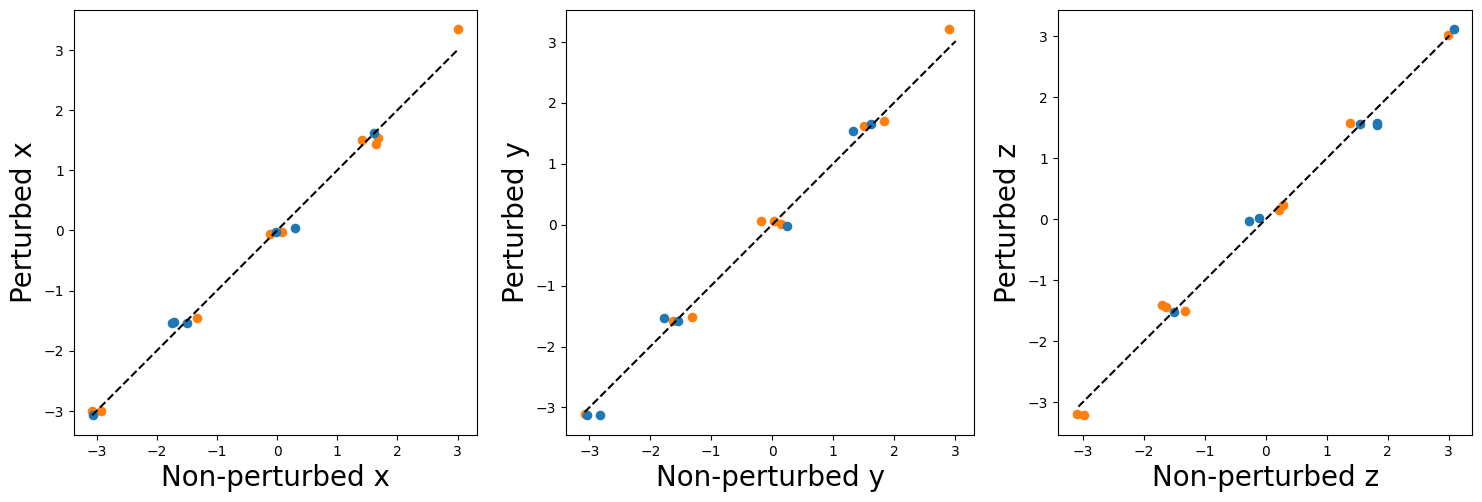

In [33]:
# Plot X0 against X1
def compare_coords(X0, X1, species):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    ax_names = ['x', 'y', 'z']

    # Coordinates of species 1 and 2
    X0_1 = X0[species == 1]
    X0_2 = X0[species == 2]

    X1_1 = X1[species == 1]
    X1_2 = X1[species == 2]

    for i, ax in enumerate(axes):
        ax.set_aspect('equal')
        ax.scatter(X0_1[:, i], X1_1[:, i], s=35, label='Species 1', color='tab:orange')
        ax.scatter(X0_2[:, i], X1_2[:, i], s=35, label='Species 2', color='tab:blue')
        ax.set_xlabel(f'Non-perturbed {ax_names[i]}', fontsize=20)
        ax.set_ylabel(f'Perturbed {ax_names[i]}', fontsize=20)

        ax.plot([np.min(X0[:, 0]), np.max(X0[:, 0])], [np.min(X0[:, 0]), np.max(X0[:, 0])], 'k--')

    plt.tight_layout()
    ax.set_aspect('equal')

    plt.show()

compare_coords(X0, X1, bcc_alloy_non_perturb.species)

## Potential difference

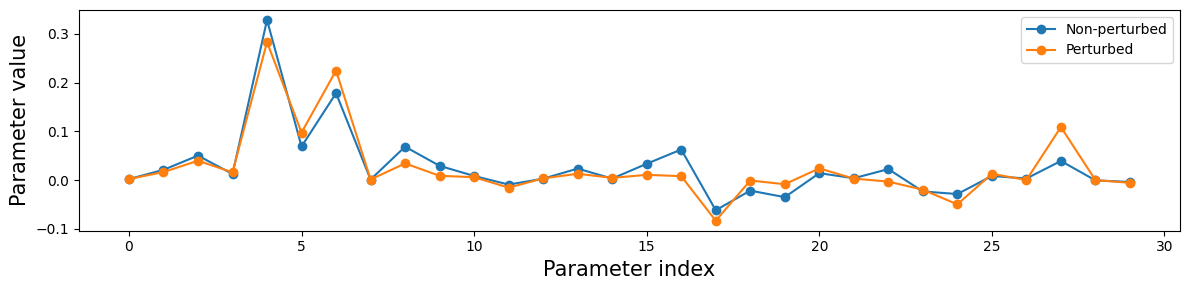

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

Theta0 = bcc_alloy_non_perturb.pot.Theta_dict['Mo']['Theta'].copy()
Theta1 = bcc_alloy_perturb.pot.Theta_dict['Mo']['Theta'].copy()

ax.plot(Theta0, marker='o', ls='-', label='Non-perturbed')
ax.plot(Theta1, marker='o', ls='-', label='Perturbed')

ax.set_xlabel('Parameter index', fontsize=15)
ax.set_ylabel('Parameter value', fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()

## Potential parameters minimization using the implicit derivative technique

In [35]:
# Re-initialize the non-perturbed system before the minimization
bcc_alloy_minim = BCC_BINARY(datafile=datafile,
                            snapcoeff_filename='NiMo.snapcoeff',
                            ncell_x=3,
                            specie_B_concentration=0.5,
                            minimize=True)


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Reading datafile bcc_random.data
Setting SNAP potential

                  SNAP coefficients for: Ni Mo
 Number of parameters (excluding beta0): 30
                                Element: Ni  |  R =  0.5750 w =  0.5000
                                Element: Mo  |  R =  0.5750 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 1 steps
Initial fmax: 2.396e-09, final fmax: 2.257e-09
Initial fnorm: 8.923e-09, final fnorm: 5.999e-09
Number of atoms: 16, largest force value: 2.257e-09, force norm: 5.999e-09


In [36]:
X0 = bcc_alloy_non_perturb.X_coord.copy()
X1 = bcc_alloy_perturb.X_coord.copy()

X_target = X0.copy() + bcc_alloy_non_perturb.minimum_image(X1 - X0)

bcc_alloy_perturb_minimized, error_array, \
min_X, min_Theta = error_tools.minimize_loss(
                            bcc_alloy_minim,
                            X_target,
                            comm=None,
                            step=1e-4,
                            adaptive_step=True,
                            maxiter=20,
                            error_tol=1e-5,
                            der_ftol=1e-4,
                            der_method='inverse',
                            der_adaptive_alpha=True,
                            der_alpha0=0.5,
                            der_maxiter=500,
                            pickle_name='bcc_alloy_minimization.pickle',
                            verbosity=3,
                            minimize_at_iters=True,
                            apply_hard_constraints=False,
                            binary=True
                            )


=======================Running the parameter optimization=======================

                 Initial error: 6.897e-01

Iteration 1 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 309.71it/s]


                     Step size: 9.644e-05

           -------------Params-------------
             Largest dX/dTheta: 3.006e+01
                Largest dTheta: 7.075e-03

           -----------Positions------------
                    Largest dX: 3.610e-01
                 Std Dev of dX: 1.382e-01

           -------------Forces-------------
           Largest force value: 1.855e+00; Norm: 4.171e+00
                        Energy: -1.2828625987e+02

           ----Forces after minimization---


           Largest force value: 6.141e-03; Norm: 1.394e-02
                        Energy: -1.2910555971e+02


           -------------Errors-------------
                 Current error: 3.422e-02
                 Actual change: 6.554e-01
Iteration 2 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 305.50it/s]


                     Step size: 2.590e-04

           -------------Params-------------
             Largest dX/dTheta: 2.145e+01
                Largest dTheta: 1.001e-03

           -----------Positions------------
                    Largest dX: 2.491e-02
                 Std Dev of dX: 1.095e-02

           -------------Forces-------------
           Largest force value: 7.242e-02; Norm: 1.724e-01
                        Energy: -1.2849878204e+02

           ----Forces after minimization---


           Largest force value: 1.053e-03; Norm: 2.772e-03
                        Energy: -1.2850172362e+02


           -------------Errors-------------
                 Current error: 3.470e-02
                 Actual change: -4.822e-04
Iteration 3 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 304.11it/s]


                     Step size: 4.026e-03

           -------------Params-------------
             Largest dX/dTheta: 9.726e+00
                Largest dTheta: 5.722e-03

           -----------Positions------------
                    Largest dX: 4.954e-02
                 Std Dev of dX: 1.974e-02

           -------------Forces-------------
           Largest force value: 4.800e-02; Norm: 9.656e-02
                        Energy: -1.2525096207e+02

           ----Forces after minimization---


           Largest force value: 1.267e-02; Norm: 2.313e-02
                        Energy: -1.2527752912e+02


           -------------Errors-------------
                 Current error: 7.126e-02
                 Actual change: -3.656e-02
Iteration 4 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 313.68it/s]


                     Step size: 3.405e-05

           -------------Params-------------
             Largest dX/dTheta: 4.452e+01
                Largest dTheta: 2.892e-04

           -----------Positions------------
                    Largest dX: 3.361e-02
                 Std Dev of dX: 1.228e-02

           -------------Forces-------------
           Largest force value: 1.737e-02; Norm: 3.518e-02
                        Energy: -1.2494794674e+02

           ----Forces after minimization---


           Largest force value: 1.465e-03; Norm: 4.309e-03
                        Energy: -1.2494850941e+02


           -------------Errors-------------
                 Current error: 7.924e-02
                 Actual change: -7.971e-03
Iteration 5 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 310.24it/s]


                     Step size: 2.133e-04

           -------------Params-------------
             Largest dX/dTheta: 3.896e+01
                Largest dTheta: 2.644e-03

           -----------Positions------------
                    Largest dX: 9.271e-02
                 Std Dev of dX: 4.277e-02

           -------------Forces-------------
           Largest force value: 9.400e-02; Norm: 1.723e-01
                        Energy: -1.2545294699e+02

           ----Forces after minimization---


           Largest force value: 6.938e-04; Norm: 2.229e-03
                        Energy: -1.2545607980e+02


           -------------Errors-------------
                 Current error: 2.601e-02
                 Actual change: 5.323e-02
Iteration 6 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 304.09it/s]


                     Step size: 6.410e-05

           -------------Params-------------
             Largest dX/dTheta: 3.851e+01
                Largest dTheta: 7.373e-04

           -----------Positions------------
                    Largest dX: 3.698e-02
                 Std Dev of dX: 1.486e-02

           -------------Forces-------------
           Largest force value: 6.530e-03; Norm: 1.608e-02
                        Energy: -1.2602539031e+02

           ----Forces after minimization---


           Largest force value: 5.026e-04; Norm: 1.350e-03
                        Energy: -1.2602550836e+02


           -------------Errors-------------
                 Current error: 2.147e-02
                 Actual change: 4.532e-03
Iteration 7 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 305.73it/s]


                     Step size: 1.559e-05

           -------------Params-------------
             Largest dX/dTheta: 7.816e+01
                Largest dTheta: 1.384e-04

           -----------Positions------------
                    Largest dX: 1.295e-02
                 Std Dev of dX: 5.589e-03

           -------------Forces-------------
           Largest force value: 1.031e-03; Norm: 2.473e-03
                        Energy: -1.2591907622e+02

           ----Forces after minimization---


           Largest force value: 1.375e-04; Norm: 3.727e-04
                        Energy: -1.2591907803e+02


           -------------Errors-------------
                 Current error: 2.072e-02
                 Actual change: 7.551e-04
Iteration 8 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 303.25it/s]


                     Step size: 1.310e-04

           -------------Params-------------
             Largest dX/dTheta: 5.186e+01
                Largest dTheta: 8.431e-05

           -----------Positions------------
                    Largest dX: 5.195e-03
                 Std Dev of dX: 2.396e-03

           -------------Forces-------------
           Largest force value: 2.084e-04; Norm: 5.578e-04
                        Energy: -1.2583183441e+02

           ----Forces after minimization---


           Largest force value: 2.099e-05; Norm: 6.056e-05
                        Energy: -1.2583183470e+02


           -------------Errors-------------
                 Current error: 2.059e-02
                 Actual change: 1.297e-04
Iteration 9 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 305.59it/s]


                     Step size: 4.853e-05

           -------------Params-------------
             Largest dX/dTheta: 4.754e+01
                Largest dTheta: 8.972e-05

           -----------Positions------------
                    Largest dX: 5.832e-03
                 Std Dev of dX: 2.424e-03

           -------------Forces-------------
           Largest force value: 3.055e-04; Norm: 5.571e-04
                        Energy: -1.2589328578e+02

           ----Forces after minimization---


           Largest force value: 1.969e-05; Norm: 4.715e-05
                        Energy: -1.2589328683e+02


           -------------Errors-------------
                 Current error: 2.046e-02
                 Actual change: 1.250e-04
Iteration 10 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 301.35it/s]


                     Step size: 5.119e-05

           -------------Params-------------
             Largest dX/dTheta: 5.327e+01
                Largest dTheta: 6.112e-05

           -----------Positions------------
                    Largest dX: 4.097e-03
                 Std Dev of dX: 1.845e-03

           -------------Forces-------------
           Largest force value: 1.202e-04; Norm: 3.079e-04
                        Energy: -1.2583413219e+02

           ----Forces after minimization---


           Largest force value: 1.320e-05; Norm: 2.597e-05
                        Energy: -1.2583413242e+02


           -------------Errors-------------
                 Current error: 2.038e-02
                 Actual change: 8.206e-05
Iteration 11 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 303.30it/s]


                     Step size: 7.157e-05

           -------------Params-------------
             Largest dX/dTheta: 4.857e+01
                Largest dTheta: 7.118e-05

           -----------Positions------------
                    Largest dX: 4.748e-03
                 Std Dev of dX: 1.964e-03

           -------------Forces-------------
           Largest force value: 2.142e-04; Norm: 4.080e-04
                        Energy: -1.2587420032e+02

           ----Forces after minimization---


           Largest force value: 9.832e-06; Norm: 2.825e-05
                        Energy: -1.2587420099e+02


           -------------Errors-------------
                 Current error: 2.032e-02
                 Actual change: 6.510e-05
Iteration 12 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 307.64it/s]


                     Step size: 3.908e-05

           -------------Params-------------
             Largest dX/dTheta: 5.393e+01
                Largest dTheta: 6.269e-05

           -----------Positions------------
                    Largest dX: 4.304e-03
                 Std Dev of dX: 1.933e-03

           -------------Forces-------------
           Largest force value: 1.323e-04; Norm: 3.386e-04
                        Energy: -1.2581514319e+02

           ----Forces after minimization---


           Largest force value: 1.339e-05; Norm: 2.997e-05
                        Energy: -1.2581514346e+02


           -------------Errors-------------
                 Current error: 2.022e-02
                 Actual change: 9.669e-05
Iteration 13 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 305.32it/s]


                     Step size: 9.517e-05

           -------------Params-------------
             Largest dX/dTheta: 4.886e+01
                Largest dTheta: 7.279e-05

           -----------Positions------------
                    Largest dX: 4.781e-03
                 Std Dev of dX: 1.977e-03

           -------------Forces-------------
           Largest force value: 2.154e-04; Norm: 4.095e-04
                        Energy: -1.2584878047e+02

           ----Forces after minimization---


           Largest force value: 1.244e-05; Norm: 3.041e-05
                        Energy: -1.2584878115e+02


           -------------Errors-------------
                 Current error: 2.016e-02
                 Actual change: 5.775e-05
Iteration 14 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 310.31it/s]


                     Step size: 3.406e-05

           -------------Params-------------
             Largest dX/dTheta: 5.470e+01
                Largest dTheta: 6.598e-05

           -----------Positions------------
                    Largest dX: 4.634e-03
                 Std Dev of dX: 2.079e-03

           -------------Forces-------------
           Largest force value: 1.459e-04; Norm: 3.772e-04
                        Energy: -1.2578726401e+02

           ----Forces after minimization---


           Largest force value: 1.116e-05; Norm: 2.874e-05
                        Energy: -1.2578726432e+02


           -------------Errors-------------
                 Current error: 2.005e-02
                 Actual change: 1.141e-04
Iteration 15 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 304.03it/s]


                     Step size: 1.160e-04

           -------------Params-------------
             Largest dX/dTheta: 4.902e+01
                Largest dTheta: 7.687e-05

           -----------Positions------------
                    Largest dX: 4.875e-03
                 Std Dev of dX: 2.025e-03

           -------------Forces-------------
           Largest force value: 2.217e-04; Norm: 4.320e-04
                        Energy: -1.2581612164e+02

           ----Forces after minimization---


           Largest force value: 1.085e-05; Norm: 3.002e-05
                        Energy: -1.2581612238e+02


           -------------Errors-------------
                 Current error: 2.000e-02
                 Actual change: 5.306e-05
Iteration 16 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 306.18it/s]


                     Step size: 3.172e-05

           -------------Params-------------
             Largest dX/dTheta: 5.525e+01
                Largest dTheta: 6.867e-05

           -----------Positions------------
                    Largest dX: 4.903e-03
                 Std Dev of dX: 2.199e-03

           -------------Forces-------------
           Largest force value: 1.584e-04; Norm: 4.110e-04
                        Energy: -1.2575225141e+02

           ----Forces after minimization---


           Largest force value: 1.624e-05; Norm: 3.905e-05
                        Energy: -1.2575225175e+02


           -------------Errors-------------
                 Current error: 1.987e-02
                 Actual change: 1.300e-04
Iteration 17 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 307.50it/s]


                     Step size: 1.336e-04

           -------------Params-------------
             Largest dX/dTheta: 4.916e+01
                Largest dTheta: 8.162e-05

           -----------Positions------------
                    Largest dX: 4.916e-03
                 Std Dev of dX: 2.061e-03

           -------------Forces-------------
           Largest force value: 2.278e-04; Norm: 4.430e-04
                        Energy: -1.2577659702e+02

           ----Forces after minimization---


           Largest force value: 1.090e-05; Norm: 3.251e-05
                        Energy: -1.2577659781e+02


           -------------Errors-------------
                 Current error: 1.981e-02
                 Actual change: 5.512e-05
Iteration 18 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 302.70it/s]


                     Step size: 3.064e-05

           -------------Params-------------
             Largest dX/dTheta: 5.556e+01
                Largest dTheta: 7.026e-05

           -----------Positions------------
                    Largest dX: 5.072e-03
                 Std Dev of dX: 2.271e-03

           -------------Forces-------------
           Largest force value: 1.661e-04; Norm: 4.323e-04
                        Energy: -1.2571127471e+02

           ----Forces after minimization---


           Largest force value: 1.673e-05; Norm: 4.085e-05
                        Energy: -1.2571127507e+02


           -------------Errors-------------
                 Current error: 1.967e-02
                 Actual change: 1.383e-04
Iteration 19 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 303.27it/s]


                     Step size: 1.511e-04

           -------------Params-------------
             Largest dX/dTheta: 4.929e+01
                Largest dTheta: 8.705e-05

           -----------Positions------------
                    Largest dX: 4.967e-03
                 Std Dev of dX: 2.104e-03

           -------------Forces-------------
           Largest force value: 2.342e-04; Norm: 4.504e-04
                        Energy: -1.2573136592e+02

           ----Forces after minimization---


           Largest force value: 1.393e-05; Norm: 3.719e-05
                        Energy: -1.2573136674e+02


           -------------Errors-------------
                 Current error: 1.961e-02
                 Actual change: 5.899e-05
Iteration 20 / 20
Computing dX/dTheta using inverse method...


Hessian: 100%|██████████| 48/48 [00:00<00:00, 308.34it/s]


                     Step size: 2.983e-05

           -------------Params-------------
             Largest dX/dTheta: 5.581e+01
                Largest dTheta: 7.183e-05

           -----------Positions------------
                    Largest dX: 5.238e-03
                 Std Dev of dX: 2.339e-03

           -------------Forces-------------
           Largest force value: 1.731e-04; Norm: 4.535e-04
                        Energy: -1.2566469120e+02

           ----Forces after minimization---


           Largest force value: 1.682e-05; Norm: 4.085e-05
                        Energy: -1.2566469157e+02


           -------------Errors-------------
                 Current error: 1.947e-02
                 Actual change: 1.468e-04

Number of iterations: 20
Converged: False
Final error: 0.019466809411194413

==================== TIMING SUMMARY: minimize_loss ===================
                                     Tag  Time (s)     Calls     
----------------------------------------------------------------------
      ▷----------------------------total  4.39520      1         
                               dX_dTheta  3.18456      20        
                       minimize at iters  0.97555      20        




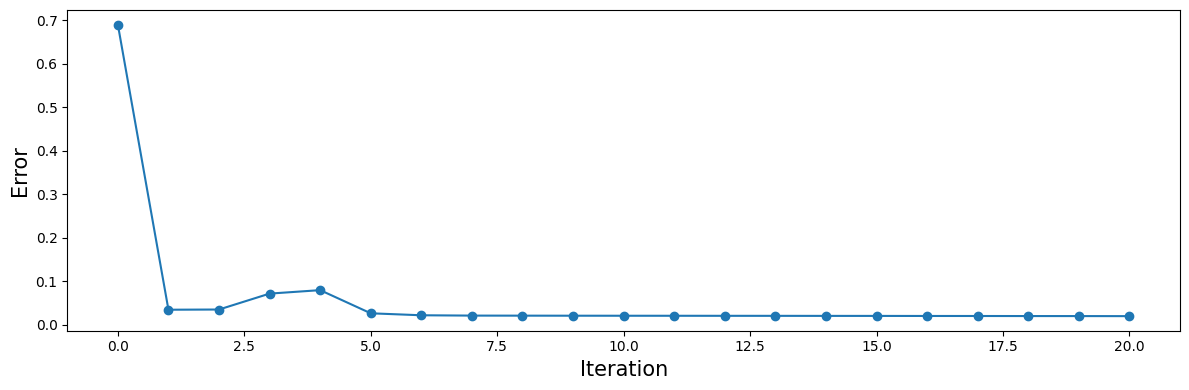

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(error_array, marker='o', ls='-')
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Error', fontsize=15)

plt.tight_layout()
plt.show()

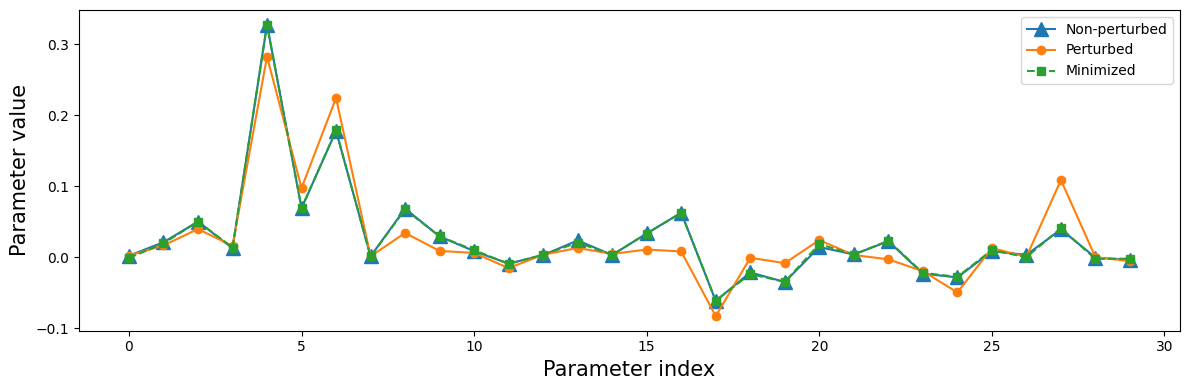

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

Theta0 = bcc_alloy_non_perturb.pot.Theta_dict['Mo']['Theta'].copy()
Theta1 = bcc_alloy_perturb.pot.Theta_dict['Mo']['Theta'].copy()
Theta2 = bcc_alloy_minim.pot.Theta_dict['Mo']['Theta'].copy()

ax.plot(Theta0, marker='^', ls='-', ms=10, label='Non-perturbed')
ax.plot(Theta1, marker='o', ls='-', label='Perturbed')
ax.plot(Theta2, marker='s', ls='--', label='Minimized')

ax.set_xlabel('Parameter index', fontsize=15)
ax.set_ylabel('Parameter value', fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()

In [39]:
X0_3D = bcc_alloy_non_perturb.X_coord.copy().reshape(-1, 3)
X1_3D = bcc_alloy_perturb.X_coord.copy().reshape(-1, 3)
min_X_3D = min_X.reshape(-1, 3)
species = bcc_alloy_non_perturb.species

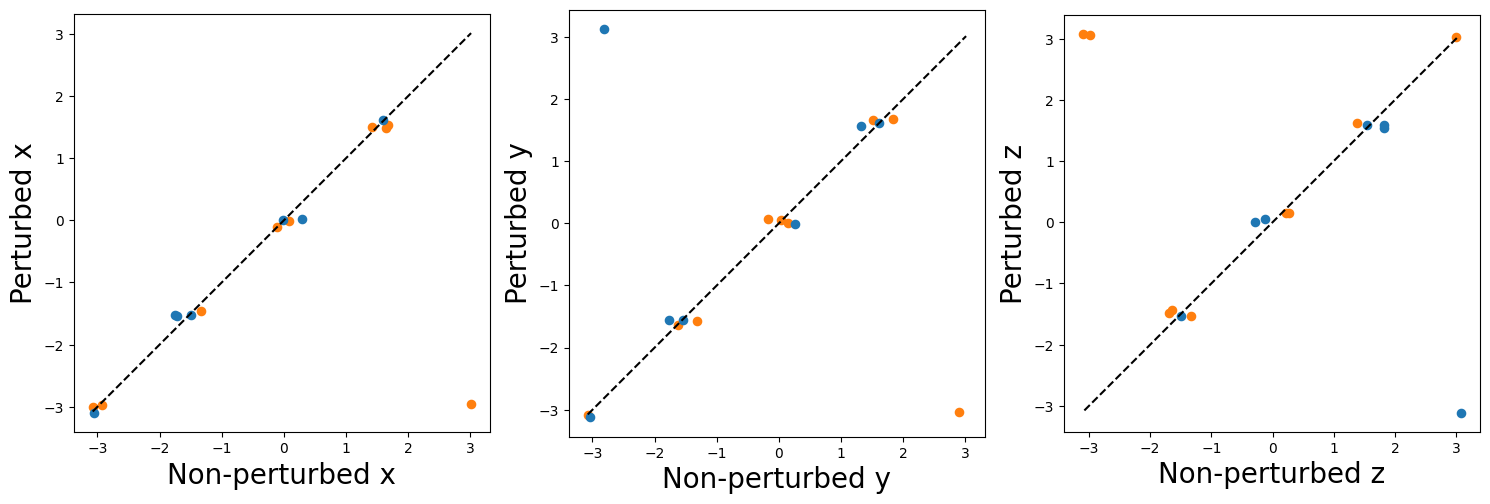

In [40]:
compare_coords(X0_3D, min_X_3D, species)

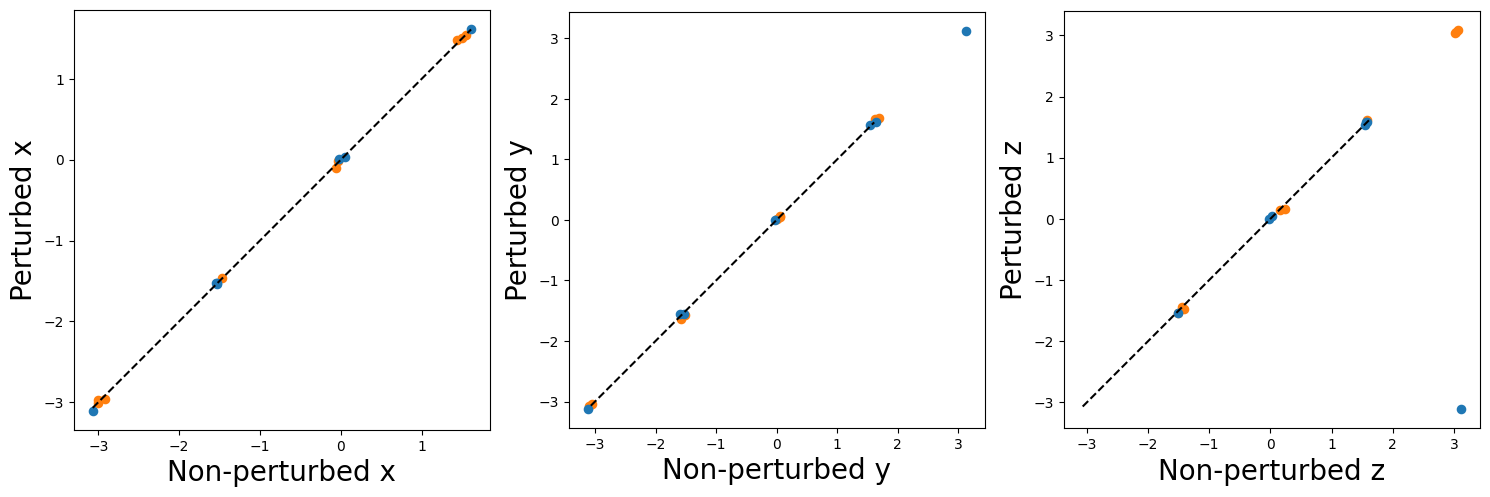

In [41]:
compare_coords(X1_3D, min_X_3D, species)